## First Trial

In [1]:
from commonfunctions import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import cv2
import pytesseract

In [2]:
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin
from skimage.measure import find_contours
from skimage.draw import rectangle
from skimage.filters import threshold_otsu

In [3]:
def load_image(file_path):
    try:
        # Load the image using OpenCV
        image = cv2.imread(file_path)
        if image is None:
            print("Error: Image not found. Check the file path.")
            return None

        # Display the image using OpenCV
        cv2.imshow('Loaded Bubble Sheet Image', image)
        show_images([image])

        cv2.waitKey(0)
        cv2.destroyAllWindows()

        return image
    
    except Exception as e:
        print(f"Error loading image: {e}")
        return None
    

### Second

In [4]:
# Function to resize image first into 500x700
def resize_image(image, target_width=500, target_height=700):
    h, w = image.shape[:2]
    aspect_ratio = w / h

    if w > h:  # Wide image
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    else:  # Tall or square image
        new_height = target_height
        new_width = int(target_height * aspect_ratio)

    # Ensure dimensions don't exceed target size
    new_width = min(new_width, target_width)
    new_height = min(new_height, target_height)

    resized = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)

    # Calculate padding
    delta_w = max(target_width - new_width, 0)
    delta_h = max(target_height - new_height, 0)
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    color = [0, 0, 0]  # Black padding
    padded_image = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return padded_image

# Function to detect the sheet contour and apply perspective transform
def detect_sheet_contour(image, width=500, height=700):
    
    image = resize_image(image, target_width=width, target_height=height)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Canny edge detection
    edges = cv2.Canny(gray, 50, 150)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours by area (largest first)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # Check if we have enough contours
    if len(contours) > 0:
        # Assume the largest contour is the sheet
        sheet_contour = contours[0]

        # Approximate the sheet's contour to a quadrilateral
        epsilon = 0.02 * cv2.arcLength(sheet_contour, True)
        approx = cv2.approxPolyDP(sheet_contour, epsilon, True)

        # Ensure we have 4 points (a quadrilateral)
        if len(approx) == 4:
            points = approx.reshape(4, 2)
            rect = np.zeros((4, 2), dtype='float32')

            s = points.sum(axis=1)
            rect[0] = points[np.argmin(s)]  # Top-left
            rect[2] = points[np.argmax(s)]  # Bottom-right

            diff = np.diff(points, axis=1)
            rect[1] = points[np.argmin(diff)]  # Top-right
            rect[3] = points[np.argmax(diff)]  # Bottom-left

            # Define the standard rectangle for the aligned sheet
            dst = np.array([
                [0, 0],
                [width - 1, 0],
                [width - 1, height - 1],
                [0, height - 1]
            ], dtype='float32')

            # Compute the perspective transform matrix
            M = cv2.getPerspectiveTransform(rect, dst)

            # Apply perspective warp
            aligned_sheet = cv2.warpPerspective(image, M, (width, height))

            # Display the aligned sheet
            cv2.imshow('Aligned Sheet', aligned_sheet)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

            return aligned_sheet
        else:
            print("Sheet alignment failed: Unable to detect 4 corners.")
            return None
    else:
        print("No contours detected.")
        return None


# Function to extract a specific box from the aligned sheet
def extract_region_from_sheet(aligned_sheet, region_coords=(125, 175, 282, 435)):
    # Extract the region based on the coordinates (y1, y2, x1, x2)
    y1, y2, x1, x2 = region_coords
    extracted_region = aligned_sheet[y1:y2, x1:x2]

    # Display the extracted region
    cv2.imshow('Extracted Region', extracted_region)
    show_images([extracted_region])
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return extracted_region

In [5]:
def extract_name(aligned_sheet, x=0, y=0, w=180,h=60):
    # Define the region where the name is located (adjust these coordinates as needed)
    #x, y, w, h = 0, 0, 180, 60  # Example coordinates
    name_region = aligned_sheet[y:y+h, x:x+w]
    
    # Step 1: Convert the name region to grayscale
    name_gray = cv2.cvtColor(name_region, cv2.COLOR_BGR2GRAY)

    # Step 2: Apply Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(name_gray, (5, 5), 0)

    # Step 4: Apply Adaptive Thresholding to isolate the text
    thresh_name = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY_INV, 11, 2)

    # Step 5: Remove small noise with morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    opened = cv2.morphologyEx(thresh_name, cv2.MORPH_OPEN, kernel, iterations=3)

    # Step 6: Apply dilation to enhance text thickness
    dilated = cv2.dilate(opened, kernel, iterations=3)

    # Step 7: Use Tesseract to extract the name text
    extracted_name = pytesseract.image_to_string(thresh_name, config='--psm 6')

    # Display results
    print("Extracted Name:", extracted_name.strip())
    
    # Optionally display intermediate and final processed images
    cv2.imshow('Grayscale', name_gray)
    cv2.imshow('Blurred', blurred)
    cv2.imshow('Thresholded', thresh_name)
    cv2.imshow('Noise Removed', opened)
    cv2.imshow('Dilated', dilated)
    show_images([thresh_name])
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return extracted_name.strip()

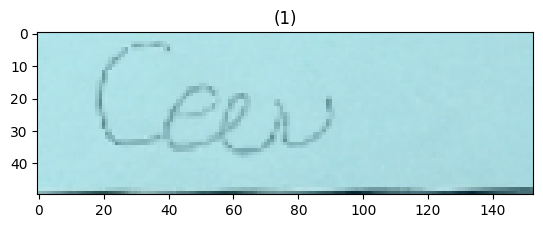

In [6]:
image_path = '2\IMG_6223.JPG'

# Load the image
image = cv2.imread(image_path)
if image is None:
    print(f"Error: Could not load the image at {image_path}")
else:
    # Step 1: Align the sheet
    aligned_sheet = detect_sheet_contour(image,500,700)

    if aligned_sheet is not None:
        # Step 2: Define the region to extract
        region_coords = (125, 175, 282, 435)  # Modify based on where the box is in the image
        extracted_region = extract_region_from_sheet(aligned_sheet, region_coords)

Extracted Name: Ce


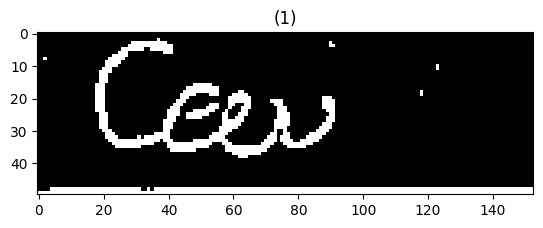

In [7]:
# Main process
def main():
    extract_name(extracted_region)
            
# Run the main function
if __name__ == "__main__":
    main()

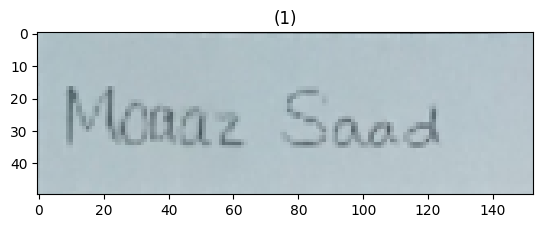

In [8]:
# Example usage:
image_path = '3\IMG_2032.jpg'

# Load the image
image = cv2.imread(image_path)
if image is None:
    print(f"Error: Could not load the image at {image_path}")
else:
    # Step 1: Align the sheet
    aligned_sheet = detect_sheet_contour(image)

    if aligned_sheet is not None:
        # Step 2: Define the region you want to extract (e.g., name box)
        region_coords = (125, 175, 282, 435)  # Modify based on where the box is in the image
        extracted_region = extract_region_from_sheet(aligned_sheet, region_coords)

Extracted Name: Monaz Sood


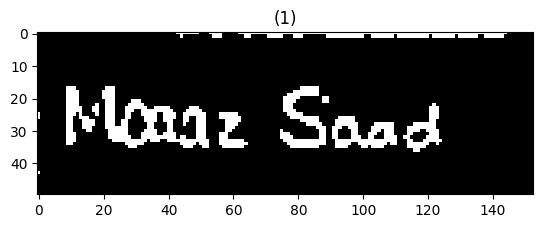

In [9]:
# Main process
def main():
    extract_name(extracted_region)
            
# Run the main function
if __name__ == "__main__":
    main()